<a href="https://colab.research.google.com/github/MattoDemente/CryptoTrading/blob/master/TOG_MachineLearning_GridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
#!pip install backtesting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [232]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import plotly.graph_objects as go
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [182]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [183]:
modelList = ['LR','LogR','SVM','DT','RF','NB','XGB','DNN'] #list of machine learning models to choose from
modelType = modelList[7]
gridsearch = False  #whether we shuould iterate/grid search over model hyperparameters
test_split_ratio = 0.15 #how much test data should we set aside
pd_profiling = False #do we went a full pandas dataframe profile report
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [342]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.BinaryAccuracy(name='categorical_accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [184]:
#Pulling BITCOIN MXN
def load_crncy(path, kind='train'):
    """Load Bitcoin MXN trade info"""
    
    data_path = os.path.join(path, 'Binance_BTCUSDT_1h_labeled_1_window_propagated_blocks.csv')
    #data_path = os.path.join(path, 'Bitso_ETHMXN_1h_20191206.csv')
    #X = np.genfromtxt(fname=data_path,delimiter=',', skip_header=2,usecols=(0,1,2,3,4,5,6,7))    
    #df = pd.read_csv(data_path, sep = ",",skiprows = 1, index_col='Date')
    df = pd.read_csv(data_path, sep = ",",skiprows = 0, index_col=0)
    #df = df.iloc[ : , 0:8]
    print('First rows of features')
    print(df.head)
    #print(df.isna().sum())
    '''
    y = np.genfromtxt(fname=data_path,delimiter=',', skip_header=1, usecols=(11))    
    print('First value of targets ',y[0])
    print('Shape of Data loaded ',X.shape, y.shape)    
    '''
    return df


In [185]:
df = load_crncy('/content/gdrive/My Drive/Colab Notebooks/BINANCE/data/')    
print(df.shape)
df.head(10)

First rows of features
<bound method NDFrame.head of                         Open     High  ...  position_block_delta_pct  positionW
2017-08-16 23:00:00  4261.48  4313.62  ...                       0.0          0
2017-08-17 00:00:00  4308.83  4328.69  ...                       0.0          0
2017-08-17 01:00:00  4330.29  4345.45  ...                       0.0          0
2017-08-17 02:00:00  4316.62  4349.99  ...                       0.0          0
2017-08-17 03:00:00  4333.32  4377.85  ...                       0.0          0
...                      ...      ...  ...                       ...        ...
2020-06-18 15:00:00  9397.99  9404.28  ...                       0.0          0
2020-06-18 16:00:00  9343.98  9390.84  ...                       0.0          0
2020-06-18 17:00:00  9371.28  9395.00  ...                       0.0          0
2020-06-18 18:00:00  9379.63  9416.65  ...                       0.0          0
2020-06-18 19:00:00  9386.32  9388.71  ...                       0.

,Open,High,Low,Close,position,propagated_position,position_block,position_close,position_block_delta_pct,positionW
2017-08-16 23:00:00,4261.48,4313.62,4261.32,4308.83,0.0,0.0,2017-08-16 23:00:00,4308.83,0.0,0
2017-08-17 00:00:00,4308.83,4328.69,4291.37,4315.32,0.0,0.0,2017-08-17 00:00:00,4315.32,0.0,0
2017-08-17 01:00:00,4330.29,4345.45,4309.37,4324.35,0.0,0.0,2017-08-17 01:00:00,4324.35,0.0,0
2017-08-17 02:00:00,4316.62,4349.99,4287.41,4349.99,0.0,0.0,2017-08-17 02:00:00,4349.99,0.0,0
2017-08-17 03:00:00,4333.32,4377.85,4333.32,4360.69,0.0,0.0,2017-08-17 03:00:00,4360.69,0.0,0
2017-08-17 04:00:00,4360.00,4445.78,4360.00,4444.00,0.0,0.0,2017-08-17 04:00:00,4444.00,0.0,0
2017-08-17 05:00:00,4441.10,4470.00,4399.81,4460.00,0.0,0.0,2017-08-17 05:00:00,4460.00,0.0,0
2017-08-17 06:00:00,4460.00,4485.39,4427.30,4427.30,0.0,0.0,2017-08-17 06:00:00,4427.30,0.0,0
2017-08-17 07:00:00,4436.06,4449.56,4411.00,4411.00,0.0,0.0,2017-08-17 07:00:00,4411.00,0.0,0
2017-08-17 08:00:00,4411.00,4459.00,4411.00,4459.00,0.0,0.0,2017-08-17 08:00:00,4459.00,0.0,0


In [186]:
df.dtypes

Open                        float64
High                        float64
Low                         float64
Close                       float64
position                    float64
propagated_position         float64
position_block               object
position_close              float64
position_block_delta_pct    float64
positionW                     int64
dtype: object

In [187]:
print(df['propagated_position'].value_counts())

 0.0    17785
-1.0     3684
 1.0     3416
Name: propagated_position, dtype: int64


In [188]:
len(df)

24885

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f6fa4f630>,
      dtype=object)

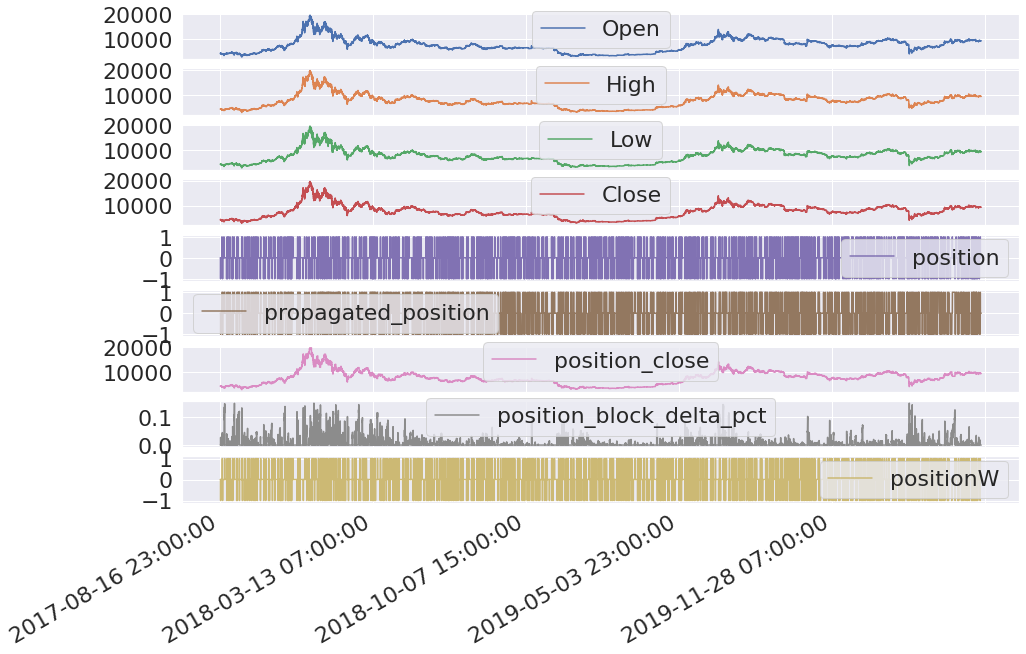

In [189]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 5}
plt.rc('font',**font)        

df.plot(figsize=(15,10),subplots=True)

In [190]:
df['position'].value_counts()

 0.0    23996
-1.0      446
 1.0      443
Name: position, dtype: int64

In [191]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df.index, y=df['Close'],
                    mode='lines',
                    name='Close'))

fig.add_trace(go.Scatter(x=df[df['propagated_position'] == -2].index, y=df[df['propagated_position'] == -2]['Close'],
                    mode='markers',
                    name='Top Sale'))
fig.add_trace(go.Scatter(x=df[df['propagated_position'] == -1].index, y=df[df['propagated_position'] == -1]['Close'],
                    mode='markers',
                    name='Sale'))
fig.add_trace(go.Scatter(x=df[df['propagated_position'] == 1].index, y=df[df['propagated_position'] == 1]['Close'],
                    mode='markers',
                    name='Buy'))
fig.add_trace(go.Scatter(x=df[df['propagated_position'] == 2].index, y=df[df['propagated_position'] == 2]['Close'],
                    mode='markers',
                    name='Top Buy'))


fig.show()


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


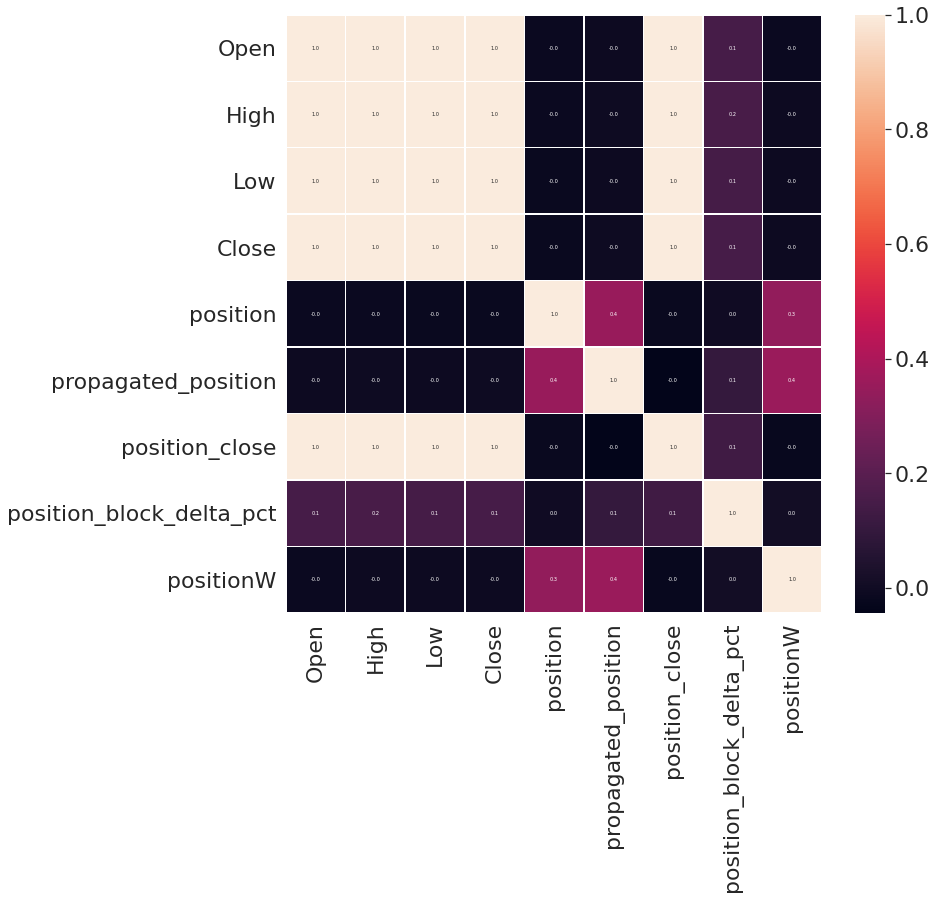

In [192]:
fig,ax = plt.subplots(figsize=(12,11))
ax = sns.heatmap(df.corr(), annot=True,linewidths=.5,fmt='.1f') #get the correlation heatmap
plt.show()

## Find Missing values (null) . None found.

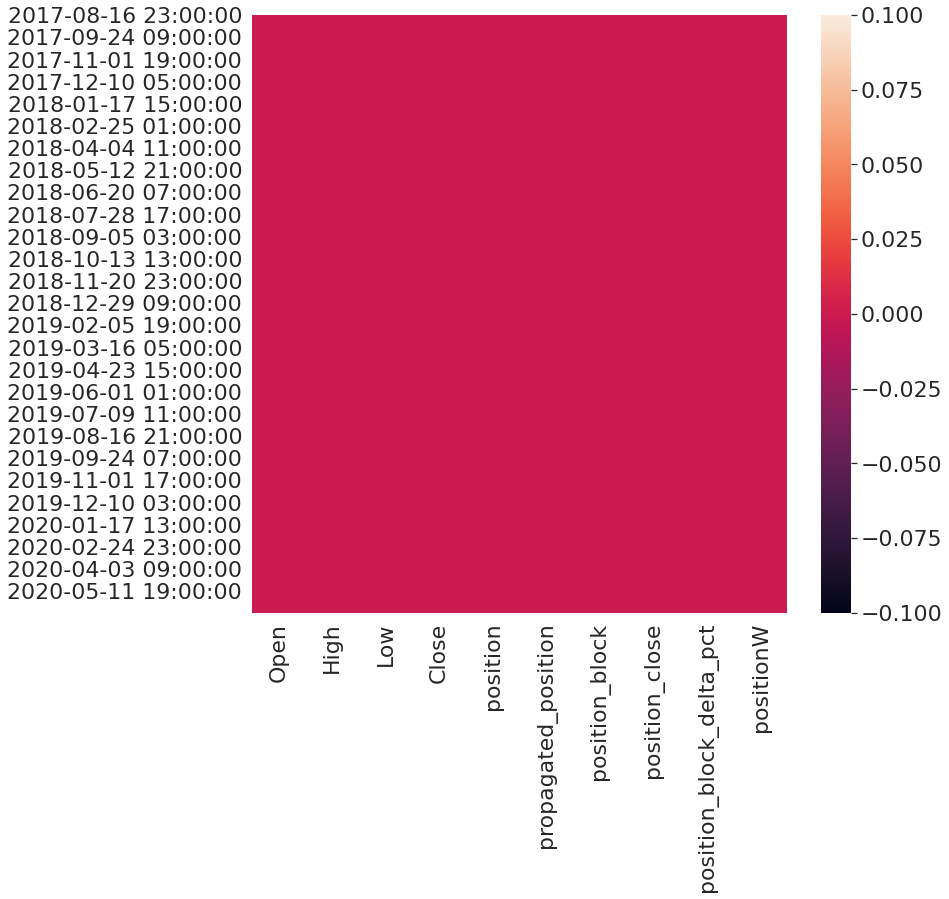

In [193]:
fig,ax = plt.subplots(figsize=(12,11))
sns.heatmap(df.isnull()) #visualize using a heatmap where are the most null values

# Conversión de Target a One-hot encoding

In [194]:
position = df['propagated_position']

In [195]:
np.unique(position)

array([-1.,  0.,  1.])

In [196]:
NUM_CLASSES = len(np.unique(position))

In [197]:
Yone_hot = tf.keras.utils.to_categorical(position, num_classes=NUM_CLASSES)
print(f"{np.unique(Yone_hot, axis=0)}")

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


# Inspeccionamos el arreglo one-hot encoded de position para confirmar qué posiciones fueron codificadas

In [198]:
df['propagated_position'].value_counts()

 0.0    17785
-1.0     3684
 1.0     3416
Name: propagated_position, dtype: int64

In [199]:
pdYoh = pd.DataFrame(Yone_hot)

In [200]:
pdYoh[0].value_counts()

1.0    17785
0.0     7100
Name: 0, dtype: int64

In [201]:
pdYoh[1].value_counts()

0.0    21469
1.0     3416
Name: 1, dtype: int64

In [202]:
pdYoh[2].value_counts()

0.0    21201
1.0     3684
Name: 2, dtype: int64

In [203]:
#pdYoh[3].value_counts()

In [204]:
#pdYoh[4].value_counts()

In [205]:
#df2['prev_position']

## Seleccionamos lista de Features del dataset de entrada

In [309]:
#Xfeatures = df2[['Open','High','Low','Close','position_block_delta_pct','prev_position']].copy(deep=True)
XFeatures = df[['Open','High','Low','Close']].copy(deep=True)
XFeatures.dropna(inplace=True)

In [310]:
Xfeatures = np.array(XFeatures)

In [312]:
Xfeatures

array([[4261.48, 4313.62, 4261.32, 4308.83],
       [4308.83, 4328.69, 4291.37, 4315.32],
       [4330.29, 4345.45, 4309.37, 4324.35],
       ...,
       [9371.28, 9395.  , 9361.37, 9379.98],
       [9379.63, 9416.65, 9367.65, 9386.32],
       [9386.32, 9388.71, 9325.16, 9371.79]])

## Scaling

In [313]:
scaler = MinMaxScaler(feature_range=(0, 1))
XFeatures_scaled= scaler.fit_transform(Xfeatures)

### Train-Test Split

In [314]:
from sklearn.model_selection import train_test_split

#perfrom a split between train and test
X_train, X_test, y_train, y_test = train_test_split(XFeatures_scaled,Yone_hot,test_size=test_split_ratio, stratify=Yone_hot, random_state=0)

#confirm the shape of X_train and X_test
print(X_train.shape)
print(X_test.shape)


print(y_train.shape)
print(y_test.shape)


(21152, 4)
(3733, 4)
(21152, 3)
(3733, 3)


In [315]:
FEATURE_LEN = X_train.shape[1]
print(FEATURE_LEN)

4


In [316]:
OUTPUT_LEN = y_train.shape[1]
print(OUTPUT_LEN)

3


In [317]:
np.unique(y_train, axis=0)

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

###Oversampling

* Step 1: oversample each class individually to match count of Original Dataset (train)

In [318]:
BUFFER_SIZE = 1000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

do_nothing_feats = X_train[np.argmax(y_train) == 0]
buy_feats = X_train[np.argmax(y_train) == 1]
sell_feats = X_train[np.argmax(y_train) == 2]

do_nothing_labels = y_train[np.argmax(y_train) == 0]
buy_labels = y_train[np.argmax(y_train) == 1]
sell_labels = y_train[np.argmax(y_train) == 2]

buy_ds = make_ds(buy_feats, buy_labels)
sell_ds = make_ds(sell_feats, sell_labels)
nothing_ds = make_ds(do_nothing_feats, do_nothing_labels)


In [319]:
print(buy_ds.element_spec)
print(sell_ds.element_spec)
print(nothing_ds.element_spec)

(TensorSpec(shape=(21152, 4), dtype=tf.float64, name=None), TensorSpec(shape=(21152, 3), dtype=tf.float32, name=None))
(TensorSpec(shape=(21152, 4), dtype=tf.float64, name=None), TensorSpec(shape=(21152, 3), dtype=tf.float32, name=None))
(TensorSpec(shape=(21152, 4), dtype=tf.float64, name=None), TensorSpec(shape=(21152, 3), dtype=tf.float32, name=None))


* Step 2: Merge generated slice structures into one dataset

In [320]:
resampled_ds = tf.data.experimental.sample_from_datasets([nothing_ds, buy_ds, sell_ds], weights=[0.40, 0.30, 0.30])
resampled_ds = resampled_ds.batch(BUFFER_SIZE).prefetch(2)

In [321]:
type(resampled_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [322]:
print(resampled_ds)

<PrefetchDataset shapes: ((None, 21152, 4), (None, 21152, 3)), types: (tf.float64, tf.float32)>


In [323]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.33333462


## Ahora que los datos están en formato Numpy array, se pueden entrenar los modelos.  Falta agregar:

* Oversampling (done)
* K-Fold Training
* Shuffling (done)

In [324]:
X_train[:6]

array([[0.40814854, 0.40344585, 0.4065133 , 0.4020726 ],
       [0.254033  , 0.24976615, 0.2576337 , 0.25135464],
       [0.33103465, 0.32945311, 0.32350164, 0.32107084],
       [0.35341893, 0.35561005, 0.35870869, 0.3583574 ],
       [0.29961933, 0.29551217, 0.30355542, 0.29766773],
       [0.03412992, 0.02943732, 0.03670332, 0.03120812]])

### Creación de Slices 
Esto ya no es necesario por el oversampling que ya creó los slices

In [325]:
#X_train_slice  = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#X_test_slice = tf.data.Dataset.from_tensor_slices((X_test, y_test))


In [326]:
#X_train_slice.element_spec

In [327]:
#X_train_slice = X_train_slice.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
#X_test_slice = test_dataset.batch(BATCH_SIZE)

In [328]:
modelType

'DNN'

In [329]:
gridsearch

False

In [344]:
#Using gridsearch for model hyperparameter tuning
from sklearn.model_selection import GridSearchCV

#Even though this is classification problem, lets find the intercept and coefficients for Multiple Linear Regression
# Multiple Linear Regression Equation fits a line: y = c + b1x1 + b2x2 + b3x3 + ... + b8x8
from sklearn.linear_model import LinearRegression

# Logistic Regression is actually a binary classfication method, it forces output variable y to be
# a discrete class as opposed to a continuous variable, by using probability of event.  
# If P(survived)>0.5, predict 1, else predict 0
#Logistic Regression Equation fits a sigmoid: Log(y/(1-y)) = -(c + b1x1 + b2x2 + b3x3 + ... + b8x8)
# y = 1/1 + e (-(c + b1x1 + b2x2 + ... + b8x8)) 
# Note: for softmax regression (multiclass), equation is et/sigma(et) - converts to multiclass
# probabilities
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

#initialize the model

if modelType == 'LR':
    model = LinearRegression()

elif modelType == 'LogR':
    if gridsearch == False:
        model = LogisticRegression()
    elif gridsearch == True:
        grid = {'penalty':['l1','l2'],'C':np.linspace(1,10,10),'solver':['liblinear']}
        model = GridSearchCV(LogisticRegression(solver='liblinear'),param_grid=grid,scoring='f1',cv=5)
    
elif modelType == 'SVM':
    if gridsearch == False:
        model = SVC(kernel='linear')
    elif gridsearch == True:
        #grid = {'C':np.linspace(1,10,10),'kernel':['linear','poly','rbf','sigmoid']} #takes too long
        grid = {'C':[1, 10],'kernel':['linear','sigmoid']}
        model = GridSearchCV(SVC(gamma='auto'),param_grid=grid,scoring='f1',cv=5)
    
elif modelType == 'DT':
    if gridsearch == False:
        model = DecisionTreeClassifier(max_depth=6)
    elif gridsearch == True:
        grid = {'criterion':['gini', 'entropy'],'max_depth':[6,7,8,9,10]}
        model = GridSearchCV(DecisionTreeClassifier(),param_grid=grid,scoring='f1',cv=5)
        
elif modelType == 'RF':
    if gridsearch == False:
        model = RandomForestClassifier(n_estimators = 1000, max_depth=6)
    elif gridsearch == True:
        grid = {'criterion':['gini', 'entropy'],'max_depth':[5,6,7],'n_estimators':[50,100,1000]}
        model = GridSearchCV(RandomForestClassifier(),param_grid=grid,scoring='explained_variance',cv=5)

elif modelType == 'NB':
    if gridsearch == False:
        model = GaussianNB()
    elif gridsearch == True:
        grid = {}
        model = GridSearchCV(GaussianNB(),param_grid=grid,scoring='explained_variance',cv=skf)
   
elif modelType == 'XGB':
    if gridsearch == False:
        model = xgb.XGBClassifier(max_depth = 8, n_estimators = 200)
    elif gridsearch == True:
        grid = {'max_depth':[4,6,8],'n_estimators':[200,400,800]}
        model = GridSearchCV(xgb.XGBClassifier(),param_grid=grid,scoring=None,cv=2)

elif modelType == 'DNN':
    import keras
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import Dropout
    from datetime import datetime
    
    %load_ext tensorboard
 
    #replaced / with \\ to make it work on Win 10
    logdir = r"logs\\scalars\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
    
    #might be needed for Win 10
    #%mkdir -p logdir
    
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

    """   
    model = Sequential()

    # Adding the input layer and the first hidden layer
    model.add(Dense(units=8, activation='relu', input_dim=FEATURE_LEN,kernel_initializer='uniform')) #input dim must match feature vector length
    # Adding the second hidden layer
    model.add(Dense(units = 32, activation = 'relu',kernel_initializer='uniform'))
    # Add a 20% dropout layer to regularize the neural network to prevent over-fitting
    #model.add(Dropout(0.2))
    # Adding the third hidden layer    
    #model.add(Dense(units = 20, activation = 'relu',kernel_initializer='uniform'))
     # Adding the fourth hidden layer    
    #model.add(Dense(units = 6, activation = 'relu',kernel_initializer='uniform'))
    # Adding the output layer
    #model.add(Dense(units = 1, activation = 'sigmoid',kernel_initializer='uniform'))
    model.add(Dense(units = OUTPUT_LEN, activation = 'softmax',kernel_initializer='uniform'))#output must match number of classes
    #using SGD for optimization
    #model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy',metrics=['accuracy'])
    #model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])
    """

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(X_train.shape[-1],)),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(3, activation='softmax'),
          #bias_initializer=output_bias),
  ])

  model.compile(
      #optimizer=keras.optimizers.Adam(lr=1e-3),
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  return model

#model = make_model()
#one line of code that trains the model based on the training data
if modelType == "DNN":

#    training_history = model.fit(
#        X_train,
#        y_train,
#        epochs =5, 
        #batch_size=128, #investigar
#        validation_split=0.1, 
#        verbose=2,
#        callbacks=[tensorboard_callback] #investigar
#        )
    model = make_model()
    model.summary()
    
    
    #call tensorboard outside of jupyter notebook in the Anaconda prompt in the same folder
    # as this jupyter notebook
    #%tensorboard --logdir logs/scalars
else:
    model.fit(X_train,y_train)



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 16)                80        
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_135 (Dense)            (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.predict(train_dataset)

In [229]:
if modelType == 'DNN':
  print(training_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


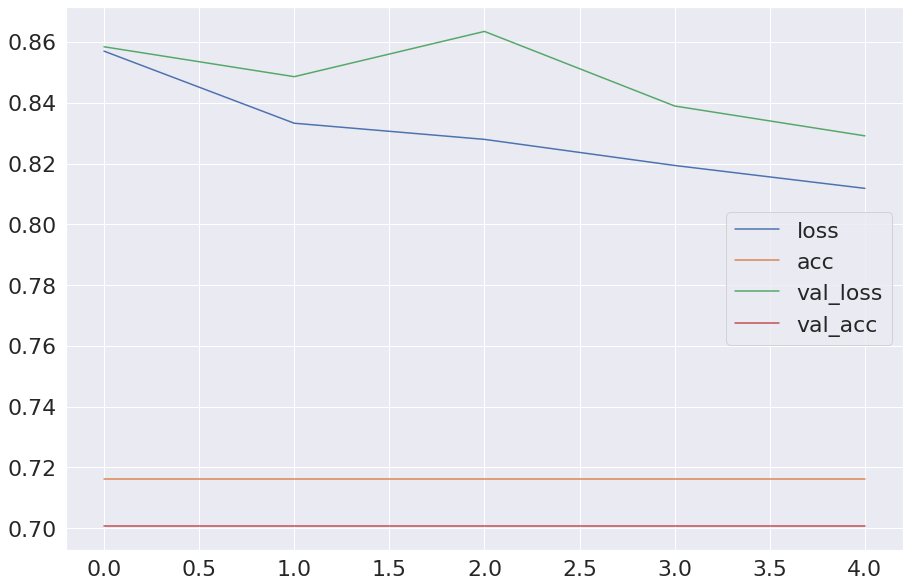

In [230]:
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(training_history.history['loss'], label='loss')
plt.plot(training_history.history['accuracy'], label='acc')
plt.plot(training_history.history['val_loss'], label='val_loss')
plt.plot(training_history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

## Now that the Machine learning model has been trained on training data, lets make predictions on the test data 

In [217]:
#one line code to predict the results on the test data
predicted_results = model.predict(X_test)

if modelType == 'DNN':
    dnn_predicted_results = predicted_results #save this for later use
    #dnn_predicted_results = dnn_predicted_results.reshape(-1)
    predicted_results = np.argmax(predicted_results, axis=1)
    #predicted_results = predicted_results.tolist()
    rshy_test = np.argmax(y_test, axis= 1)
    


    #print(dnn_predicted_results)
    #convert 2d numpy array of probabilities to 1d array of binary predicted results
    #class_labels = np.where(predicted_results>0.5, 1, 0)
    #predicted_results = class_labels.reshape(-1)
    #sanity check to see how many unique class_labels do we have
    unique, counts = np.unique(predicted_results, return_counts=True)
    dictcount= dict(zip(unique, counts))
    #rshy_test = y_test.reshape(-1)

In [218]:
predictedDF = pd.DataFrame(predicted_results)
predictedDF[0].value_counts()

0    3733
Name: 0, dtype: int64

In [219]:
predictedDF.to_csv('/content/gdrive/My Drive/Colab Notebooks/BINANCE/data/predictions.csv')

In [220]:
np.where(np.argmax(dnn_predicted_results, axis=1) == 2)

(array([], dtype=int64),)

In [221]:
dnn_predicted_results[0]

array([0.7104922 , 0.13906576, 0.15044205], dtype=float32)

In [222]:
from sklearn import tree  

if modelType == 'LR':
    #obtain and view model attributes for Linear Regression
    coefficients = model.coef_
    intercept = model.intercept_
    print(coefficients)
    print(intercept)

elif modelType == 'LogR':
    #obtain and view model attributes for Logistic Regression
    if gridsearch == False:
        coefficients = model.coef_[0]
        intercept = model.intercept_[0]
    elif gridsearch == True:
        print(model.best_params_)
        print(model.cv_results_)
        coefficients = model.best_estimator_.coef_[0]
        intercept = model.best_estimator_.intercept_[0]
    print(coefficients)
    print(intercept)

elif modelType == 'SVM':
    #obtain and view model attributes for SVM
    if gridsearch == False:
        coefficients = model.coef_[0]
        intercept = model.intercept_[0]
        #print model features for SVM
        print(model.coef_)
    
    elif gridsearch == True:
        print(model.best_params_)
        print(model.cv_results_)
        coefficients = model.best_estimator_.coef_[0]
        intercept = model.best_estimator_.intercept_[0]

    feat_importances = pd.Series(coefficients, index=Xdf.columns)
    feat_importances.nlargest(8).plot(kind='barh')    

elif modelType == 'DT':
    #obtain and view model attributes for Decision Tree
    fig, ax = plt.subplots(figsize=(24,24))
    if gridsearch == True:
        print(model.best_params_)
        print(model.cv_results_)
        tree.plot_tree(model.best_estimator_,class_names=True,precision=2,rounded=True,rotate=True,feature_names=Xdf.columns,fontsize=12,filled=True,max_depth=3,ax=ax)   
    elif gridsearch == False:
        tree.plot_tree(model,class_names=True,precision=2,rounded=True,rotate=True,feature_names=Xdf.columns,fontsize=12,filled=True,max_depth=3,ax=ax)         
    plt.show()

elif modelType == 'RF':
    #obtain and view model attributes for Decision Tree
    fig, ax = plt.subplots(figsize=(24,24))
    if gridsearch == True:
        print(model.best_params_)
        print(model.cv_results_)
        #plot one of the decision trees from the random forest
        tree.plot_tree(model.best_estimator_.estimators_[9],class_names=True,precision=2,rounded=True,rotate=True,feature_names=Xdf.columns,fontsize=12,filled=True,max_depth=3,ax=ax)   
        print(model.best_estimator_.feature_importances_)
        feat_importances = pd.Series(model.best_estimator_.feature_importances_, index=Xdf.columns)
    elif gridsearch == False:
        #plot one of the decision trees from the random forest
        tree.plot_tree(model.estimators_[9],class_names=True,precision=2,rounded=True,rotate=True,feature_names=Xdf.columns,fontsize=12,filled=True,max_depth=3,ax=ax)   
        print(model.feature_importances_)
        feat_importances = pd.Series(model.feature_importances_, index=Xdf.columns)
    
    #feat_importances.nlargest(8).plot(kind='barh')
    plt.show()
    
elif modelType == 'DNN':
    from keras.utils import plot_model
    plot_model(model, to_file='/content/gdrive/My Drive/Colab Notebooks/Machine_Learning_HPI_Training/adult_income_DNN_model.png',show_shapes = True)

## Now lets find out how well did our trained model perform on the test data by comparing predicted_results with actual results

First, we look at confusion matrix, that shows you a matrix of actual resutls vs predicted results.  This allows us to find out False positives, False negatives, Precision and Recall

Second, we look at overall model accuracy (using 2 methods, one from sklearn and one from pandas_ml library)

Observe that most models got close to 80% accuracy!! Print the values to a file so you can compare the best accuracy and the best model later

In [223]:
y_test.shape

(3733, 3)

In [224]:
rshy_test.shape

(3733,)

In [225]:
predicted_results.shape

(3733,)

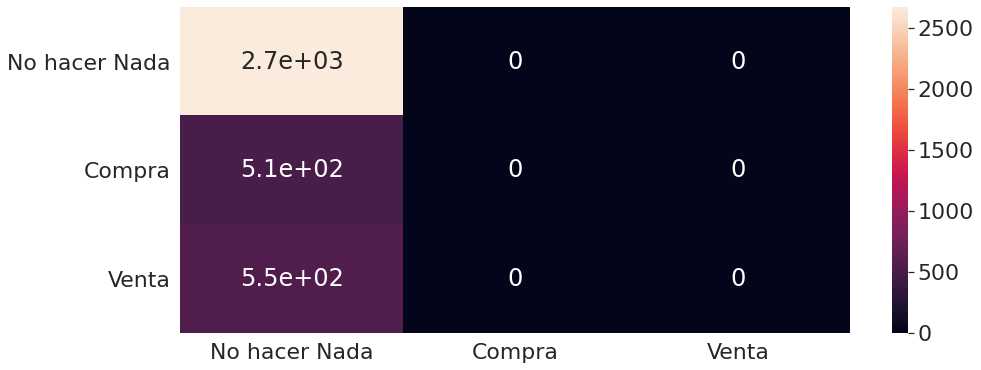

In [244]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(rshy_test,predicted_results)

labels = ['No hacer Nada','Compra', 'Venta']  
cf_matrix_df = pd.DataFrame(cf_matrix,labels,labels)                      
plt.figure(figsize=(15,6)) 
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
sns.set(font_scale=2) 
sns.heatmap(cf_matrix_df, annot=True)

In [227]:
cf_matrix_df 


,No hacer Nada,Compra,Venta
No hacer Nada,2668,0,0
Compra,512,0,0
Venta,553,0,0


## Aquí sigue backtesting de la predicción